In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

TRAFFIC_DIRECTION = 'sent'

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

traffic_training_complete = pd.read_csv(r'./data/dataset_7day_traffic.csv', index_col=0)
traffic_training_processed_complete = traffic_training_complete[[TRAFFIC_DIRECTION]]
traffic_training_scaled_complete = scaler.fit_transform(traffic_training_processed_complete)


In [3]:
# plt.plot(time, sin, label='sine (with noise)');
# plt.legend();
traffic_training_scaled_complete

array([[0.08758806],
       [0.06229327],
       [0.08449161],
       ...,
       [0.24204342],
       [0.15304432],
       [0.34646373]])

# Data Preprocessing

In [4]:
df = pd.DataFrame(traffic_training_scaled_complete, columns=[TRAFFIC_DIRECTION])
df.head(5)

df_original = pd.DataFrame(traffic_training_processed_complete, columns=[TRAFFIC_DIRECTION])
df_original.head(5)

,sent
1583452800,266.118578
1583452860,218.151409
1583452920,260.246688
1583452980,122.211736
1583453040,142.652861


In [5]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

train_original, test_original = df_original.iloc[0:train_size], df_original.iloc[train_size:len(df_original)]

test.head()

8652 2163


,sent
8652,0.092050
8653,0.096599
8654,0.085330
8655,0.026855
8656,0.046166


In [6]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [7]:
time_steps = 60

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train[TRAFFIC_DIRECTION], time_steps)
X_test, y_test = create_dataset(test, test[TRAFFIC_DIRECTION], time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8592, 60, 1) (8592,)
(2103, 60, 1) (2103,)


# Modeling

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Dense(1))

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

# model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Training

In [9]:
history = model.fit(
    X_train, y_train, 
    epochs=5, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1
)


Train on 7732 samples, validate on 860 samples
Epoch 1/5
7732/7732 [==============================] - 97s 13ms/sample - loss: 0.0112 - val_loss: 0.0105
Epoch 2/5
7732/7732 [==============================] - 84s 11ms/sample - loss: 0.0086 - val_loss: 0.0098
Epoch 3/5
7732/7732 [==============================] - 86s 11ms/sample - loss: 0.0083 - val_loss: 0.0104
Epoch 4/5
7732/7732 [==============================] - 84s 11ms/sample - loss: 0.0081 - val_loss: 0.0098
Epoch 5/5
7732/7732 [==============================] - 86s 11ms/sample - loss: 0.0079 - val_loss: 0.0096


## Evaluation

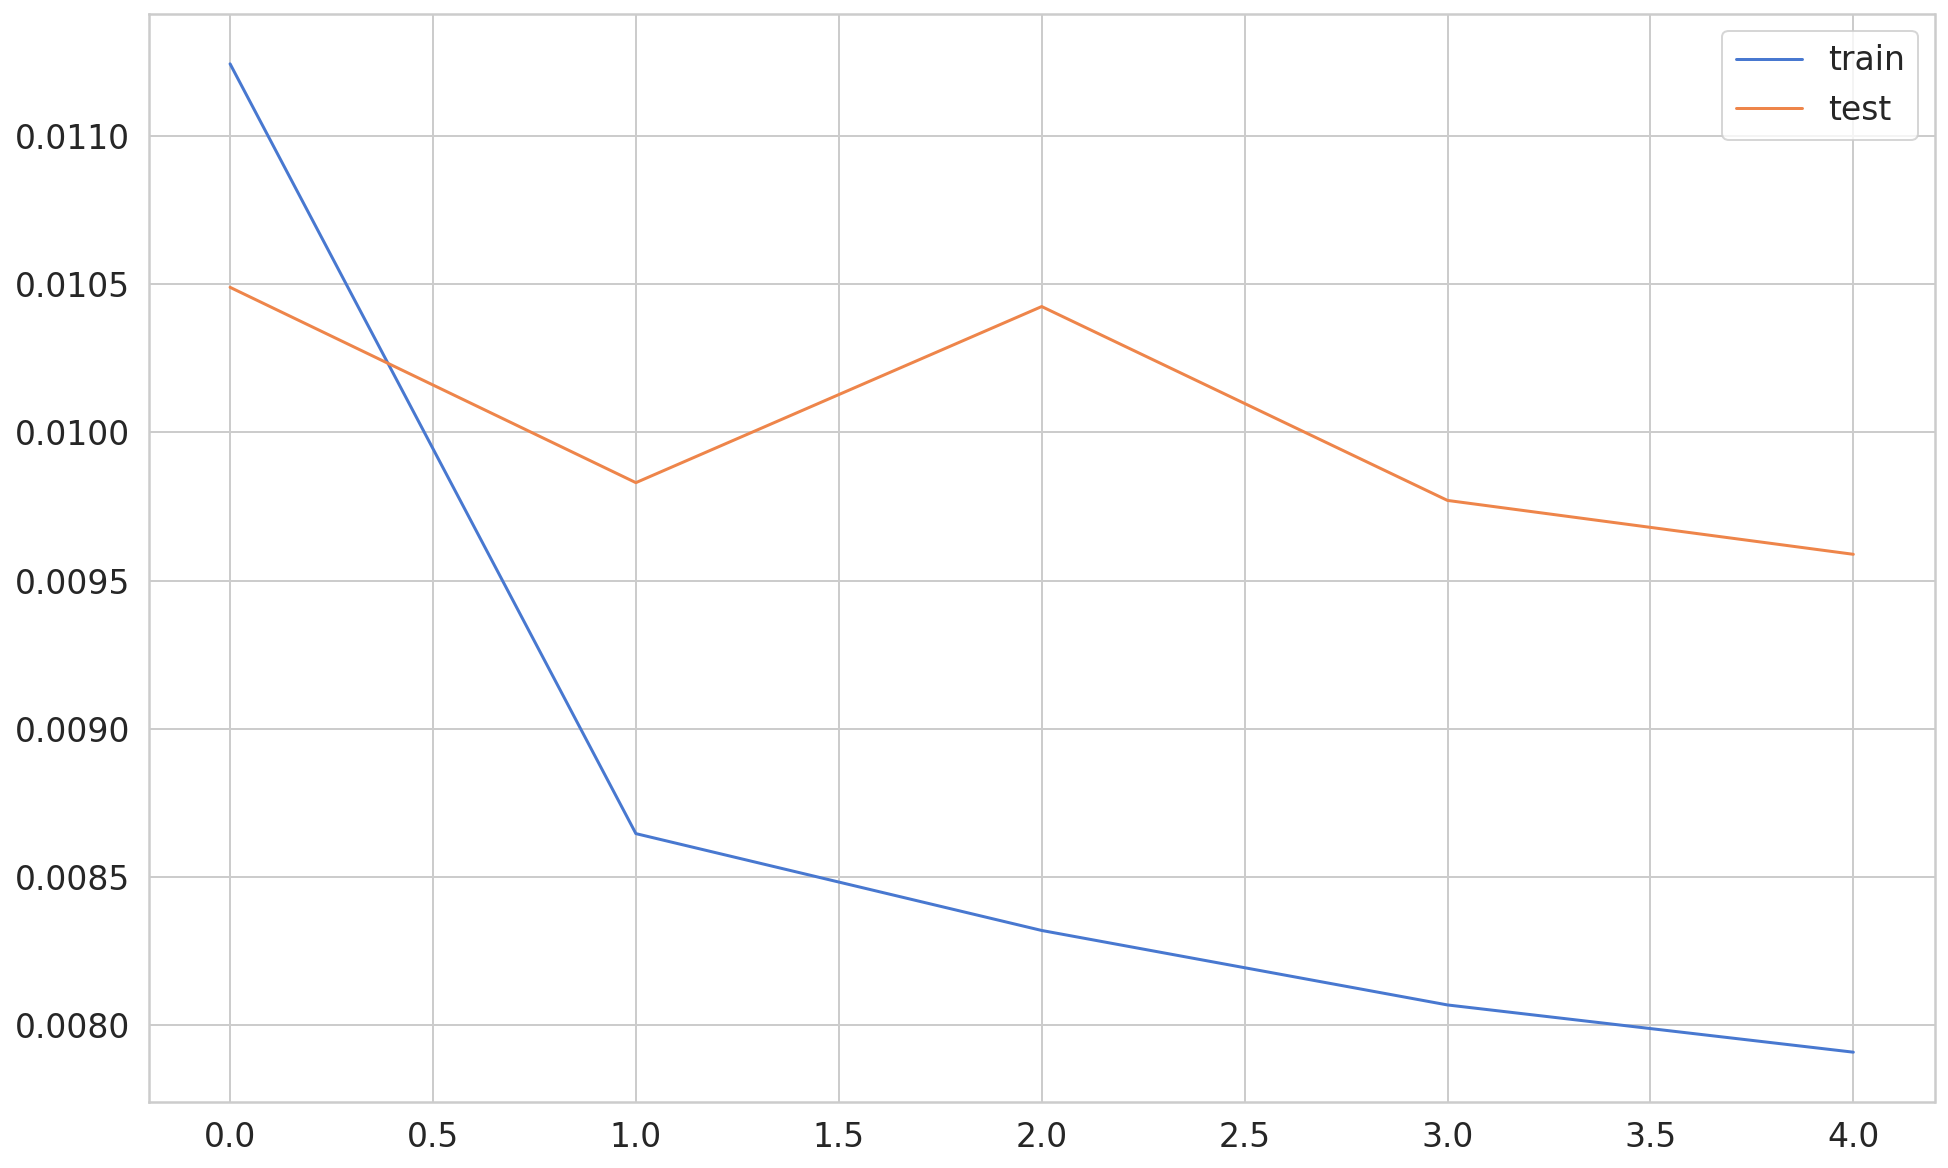

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [11]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test.shape

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train.shape

y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

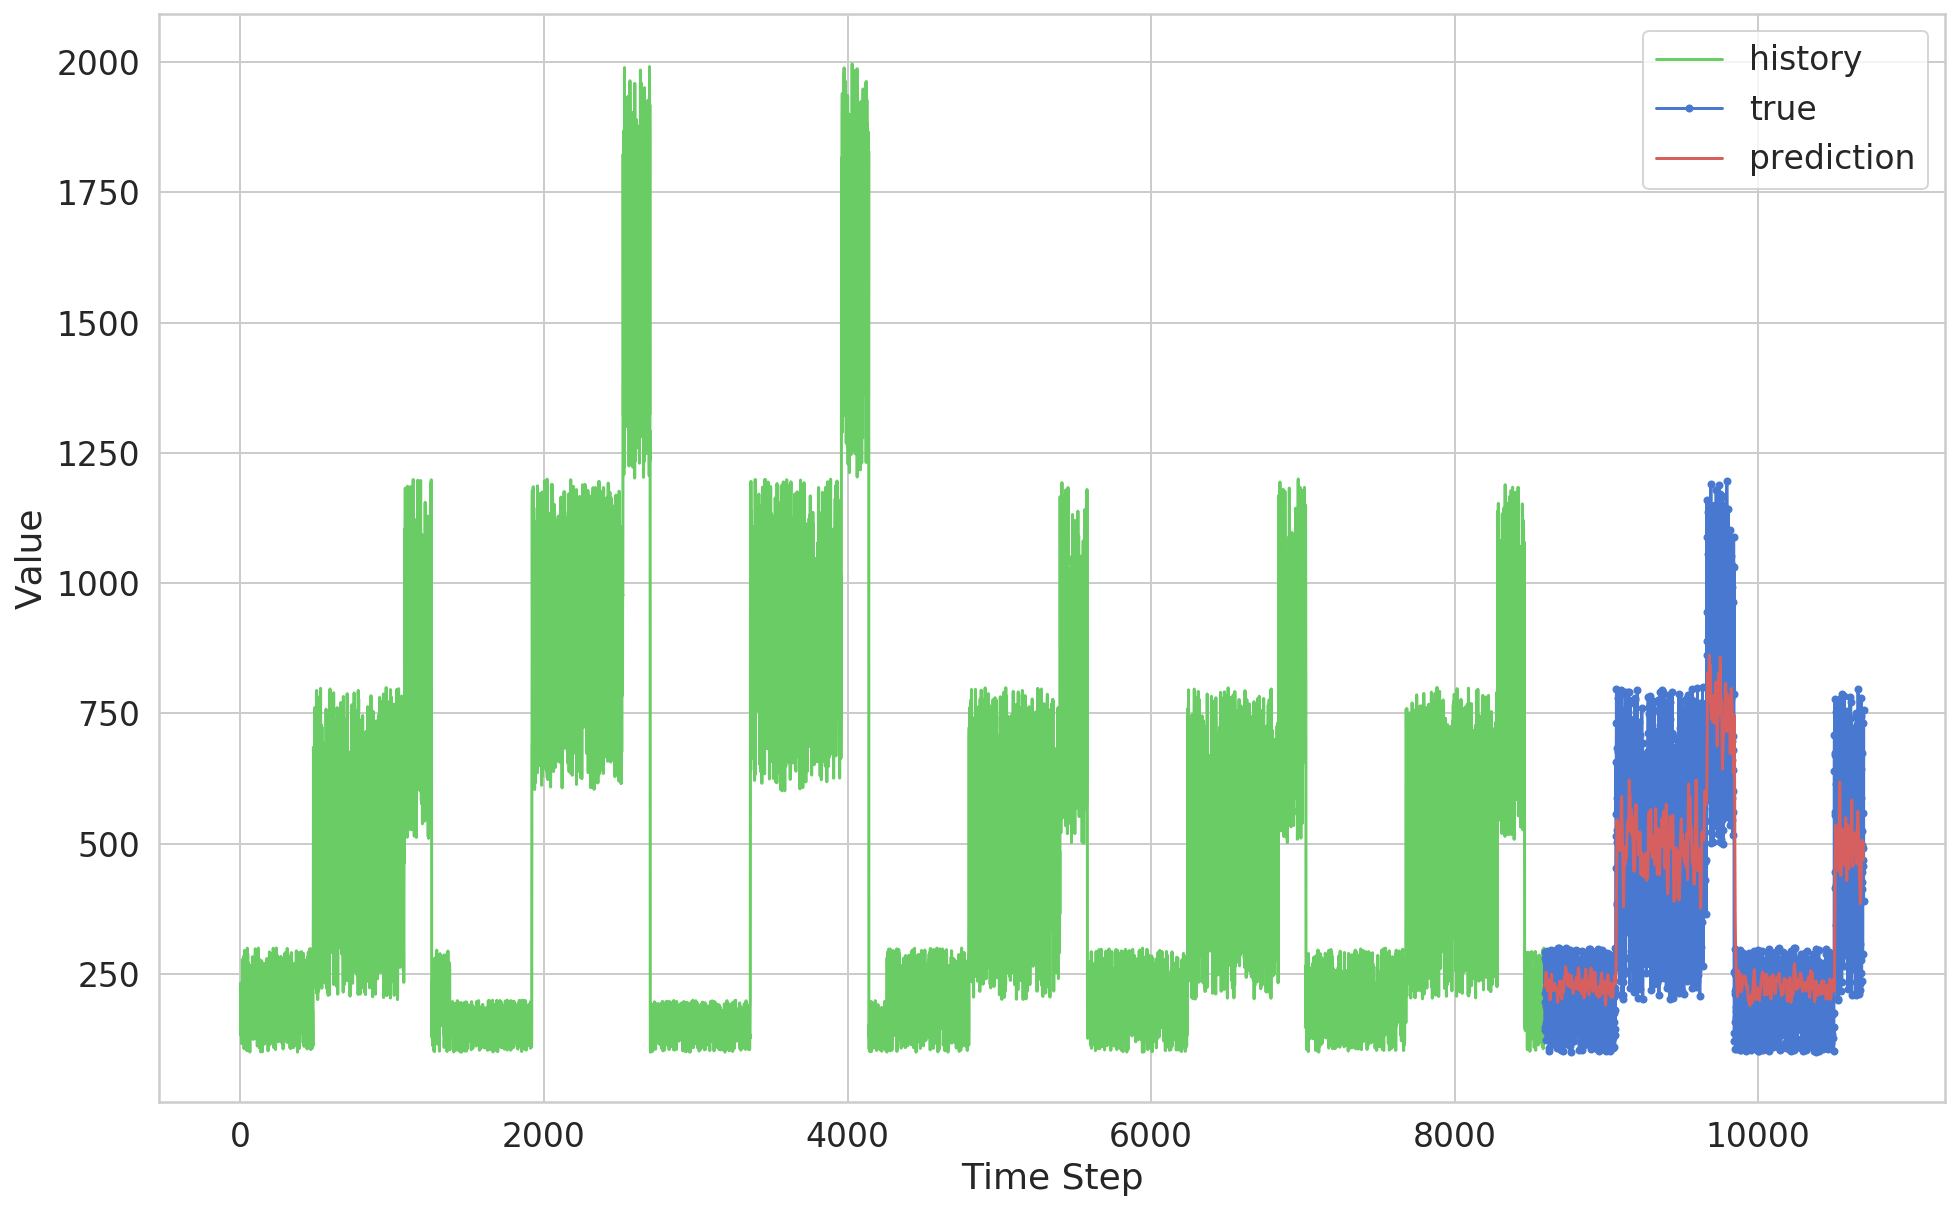

In [12]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

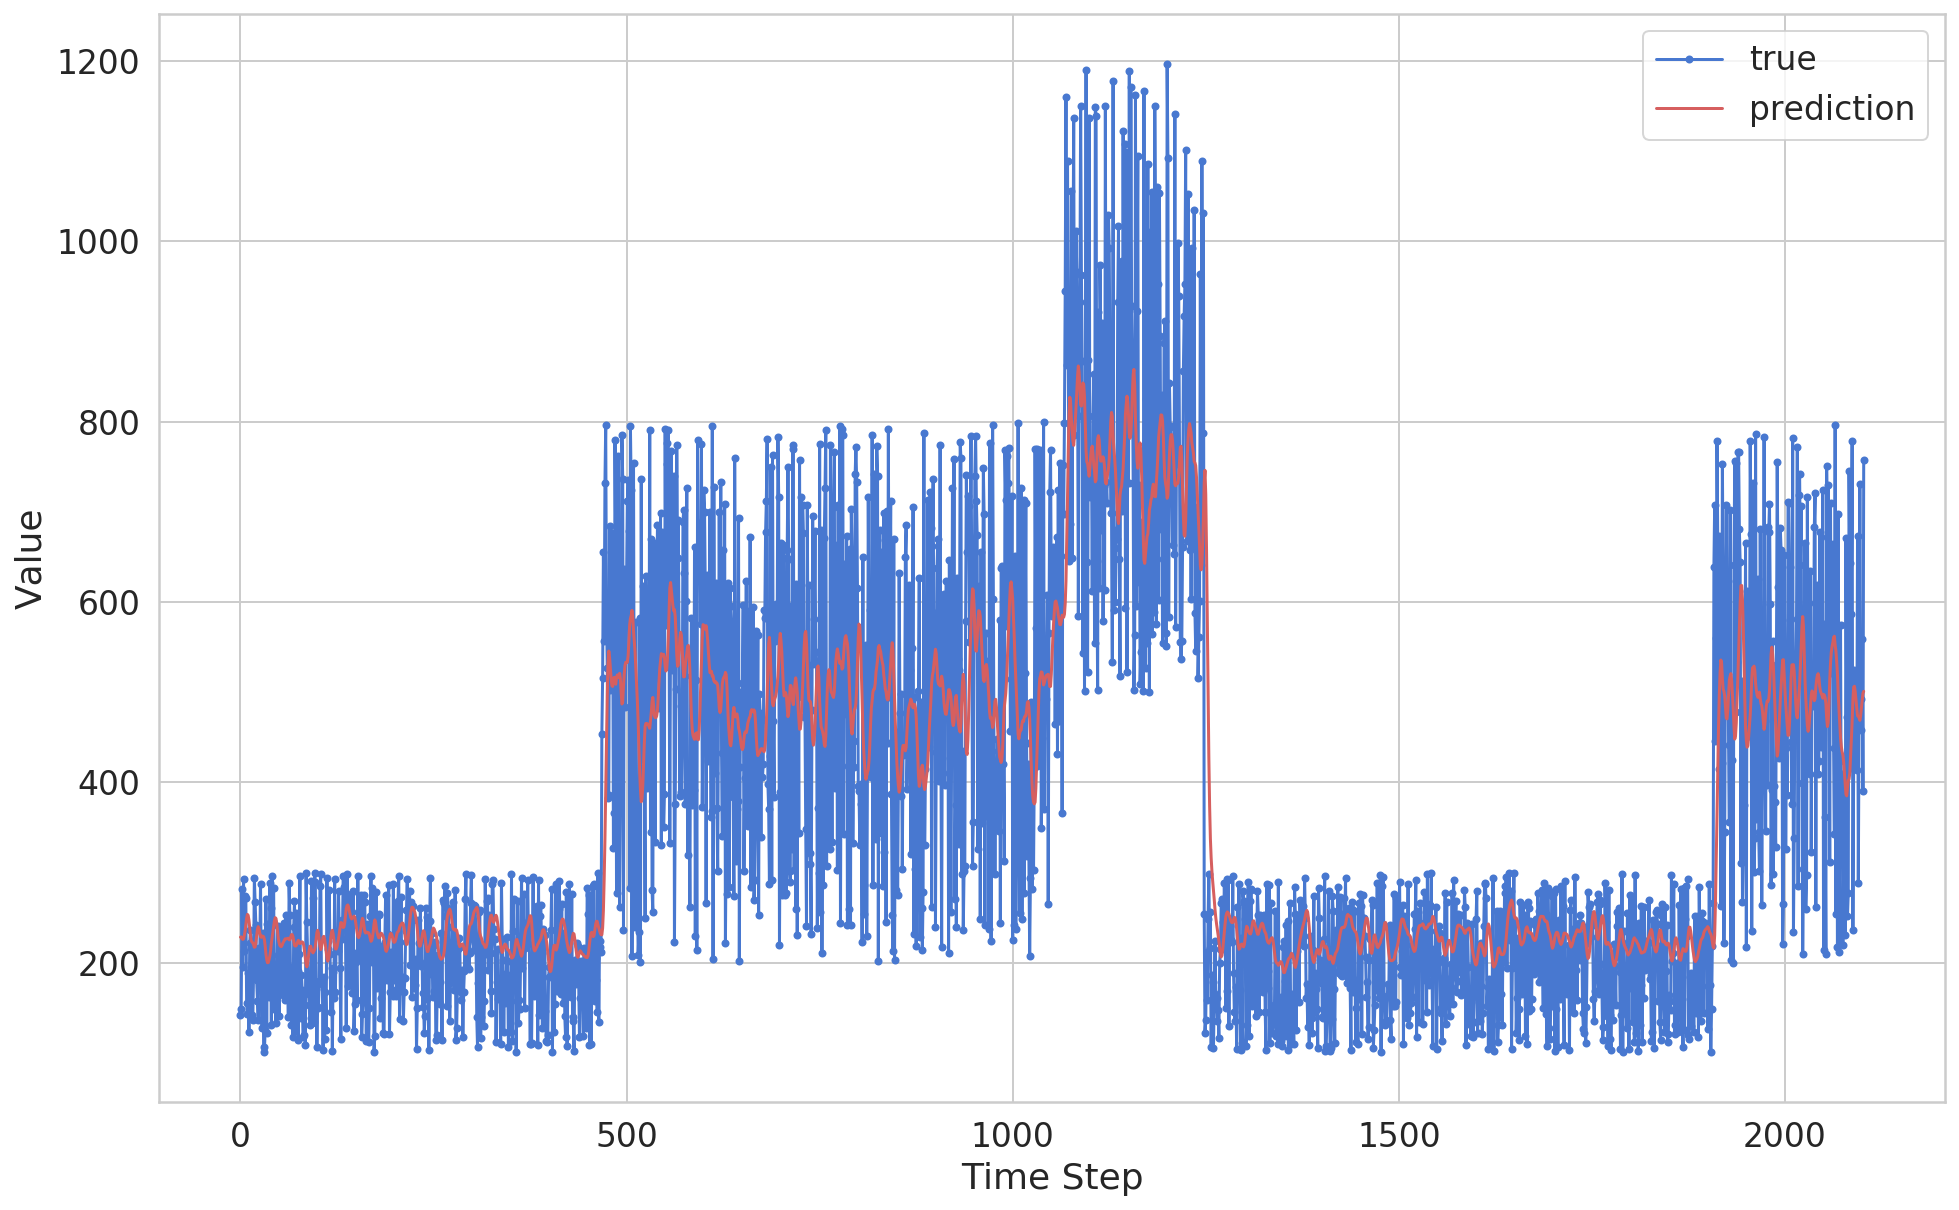

In [13]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();